In [1]:
import os
import pandas as pd
import numpy as np
import joblib

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

In [121]:

class AttritionModel:
    def __init__(self, data_path):
        """
        Initialise l'objet avec le chemin des données et définit les attributs nécessaires.

        Entrée :
        - data_path (str) : Chemin du fichier contenant les données.

        Sortie :
        - Aucun retour, mais initialise plusieurs attributs de la classe.
        """
        self.data_path = data_path
        self.current_working_directory = os.getcwd()
        self.numerical_columns = []
        self.categorical_columns = []
        self.full_pipeline = None
        self.models = {}
        self.tab_mean = []
    
    def load_data(self):
        """
        Charge les données depuis un fichier Excel et sépare les variables explicatives et la variable cible.

        Entrée :
        - Aucun paramètre en entrée.

        Sortie :
        - Initialise les attributs :
            - self.X (pd.DataFrame) : Variables explicatives après suppression de certaines colonnes inutiles.
            - self.y (pd.Series) : Variable cible (Attrition) convertie en valeurs numériques.
            - self.numerical_columns (list) : Liste des colonnes numériques.
            - self.categorical_columns (list) : Liste des colonnes catégorielles.
        """
        df = pd.read_excel(self.data_path)
        self.X = df.drop(columns=['EmployeeNumber', 'Attrition', 'Over18', 'EmployeeCount'], axis=1)
        self.y = df['Attrition'].map({'Yes': 1, 'No': 0})
        self.numerical_columns = self.X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.categorical_columns = self.X.select_dtypes(include=['object']).columns.tolist()
        
    def split_data(self, test_size=0.2, random_state=42):
        """
        Charge les données depuis un fichier Excel et sépare les variables explicatives et la variable cible.

        Entrée :
        - Aucun paramètre en entrée.

        Sortie :
        - Initialise les attributs :
            - self.X (pd.DataFrame) : Variables explicatives après suppression de certaines colonnes inutiles.
            - self.y (pd.Series) : Variable cible (Attrition) convertie en valeurs numériques.
            - self.numerical_columns (list) : Liste des colonnes numériques.
            - self.categorical_columns (list) : Liste des colonnes catégorielles.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
    
    def build_pipeline(self):
        """
        Construit un pipeline de transformation des données pour les colonnes numériques et catégorielles.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Initialise l'attribut :
            - self.full_pipeline (ColumnTransformer) : Pipeline de transformation des données.
        """
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scaler', StandardScaler())
        ])
        
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.numerical_columns = self.X.select_dtypes(include=['number']).columns.tolist()
        self.categorical_columns = self.X.select_dtypes(include=['object']).columns.tolist()

        self.full_pipeline = ColumnTransformer([
            ('num', num_pipeline, self.numerical_columns),
            ('cat', cat_pipeline, self.categorical_columns)
        ])

    def transform_data(self):
        """
        Applique le pipeline de transformation aux données d'entraînement et de test, puis sauvegarde le pipeline.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Enregistre le pipeline sur disque (fichier 'full_pipeline.pkl').
        - Initialise les attributs :
            - self.out_train (np.array) : Données transformées d'entraînement.
            - self.out_test (np.array) : Données transformées de test.
        """
        self.full_pipeline.fit(self.X_train)
        pipeline_dir = os.path.join(self.current_working_directory, "pipeline")
        os.makedirs(pipeline_dir, exist_ok=True)
        joblib.dump(self.full_pipeline, os.path.join(pipeline_dir, "full_pipeline.pkl"))
        self.out_train = self.full_pipeline.transform(self.X_train)
        self.out_test = self.full_pipeline.transform(self.X_test)
    
    def train_decision_tree(self):
        """
        Entraîne un modèle d'arbre de décision et le sauvegarde.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/DecisionTree.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        dt_model = DecisionTreeClassifier()
        dt_model.fit(self.out_train, self.y_train)
        mean_score = self.cross_validate_model(dt_model)
        self.tab_mean.append(mean_score)
        model_dir = os.path.join(self.current_working_directory, "model")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(dt_model, os.path.join(model_dir, "DecisionTree.model"))
        self.models["DecisionTree"] = dt_model
        #print(f"Modèle DecisionTree sauvegardé dans {model_dir}/DecisionTree.model avec un score moyen de {mean_score}")

    def train_random_forest(self):
        """
        Entraîne un modèle de forêt aléatoire et le sauvegarde.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/RandomForest.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(self.out_train, self.y_train)
        mean_score = self.cross_validate_model(rf_model)
        self.tab_mean.append(mean_score)
        model_dir = os.path.join(self.current_working_directory, "model")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(rf_model, os.path.join(model_dir, "RandomForest.model"))
        self.models["RandomForest"] = rf_model
        #print(f"Modèle random forest sauvegardé dans {model_dir}/RandomForest.model avec un score moyen de {mean_score}")

    def train_perceptron(self):
        """
        Entraîne un modèle Perceptron et le sauvegarde.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/Perceptron.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        perceptron_model = Perceptron(eta0=0.001, max_iter=10000, penalty='l2', alpha=0.0001)
        perceptron_model.fit(self.out_train, self.y_train)
        mean_score = self.cross_validate_model(perceptron_model)
        self.tab_mean.append(mean_score)
        model_dir = os.path.join(self.current_working_directory, "model")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(perceptron_model, os.path.join(model_dir, "Perceptron.model"))
        self.models["Perceptron"] = perceptron_model
        #print(f"Modèle Perceptron sauvegardé dans {model_dir}/Perceptron.model avec un score moyen de {mean_score}")

    def re_train_perceptron(self):
        """
        Entraîne un modèle Perceptron et le sauvegarde.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Sauvegarde le modèle entraîné dans le répertoire 'model/Perceptron.model'.
        - Ajoute le modèle à l'attribut self.models.
        - Ajoute le score moyen de validation croisée à self.tab_mean.
        """
        model_dir = os.path.join(self.current_working_directory, "model")
        if os.path.isdir(os.path.join(model_dir, "Perceptron_retrain.model")):
            pathto_perceptron_model = os.path.join(model_dir, "Perceptron_retrain.model")
        else:
            pathto_perceptron_model = os.path.join(model_dir, "Perceptron.model")
        perceptron_model = joblib.load( pathto_perceptron_model)
        perceptron_model.partial_fit(self.out_train, self.y_train)
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(perceptron_model, os.path.join(model_dir, "Perceptron_retrain.model"))
        self.models["Perceptron"] = perceptron_model
        #print(f"Modèle Perceptron sauvegardé dans {model_dir}/Perceptron_retrain.model")

    def train_models(self):
        """
        Entraîne tous les modèles disponibles (arbre de décision, forêt aléatoire, perceptron).

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Entraîne et sauvegarde tous les modèles.
        """
        self.train_decision_tree()
        self.train_random_forest()
        self.train_perceptron()

    def cross_validate_model(self, model, cv=5):
        """
        Entraîne tous les modèles disponibles (arbre de décision, forêt aléatoire, perceptron).

        Entrée :
        - Aucun paramètre.

        Sortie :
        - Entraîne et sauvegarde tous les modèles.
        """
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(model, self.out_train, self.y_train, cv=kf, scoring='accuracy')
        #print(f"Scores K-Fold Cross-Validation : {scores}")
        #print(f"Score moyen : {np.mean(scores)}")
        return np.mean(scores)

    def evaluate_models(self):
        """
        Évalue les modèles entraînés en utilisant diverses métriques et retourne les résultats sous forme de DataFrame.

        Entrée :
        - Aucun paramètre.

        Sortie :
        - results_df (pd.DataFrame) : Résumé des performances des modèles (Accuracy, Precision, Recall, AUC, etc.).
        """
        results = {}
        self.value_roc = []
        i = 0
        for name, model in self.models.items():
            y_pred = model.predict(self.out_test)
            if name == 'Perceptron':
                self.y_probas = model.decision_function(self.out_test)
            else:
                self.y_probas = model.predict_proba(self.out_test)
                self.y_probas = self.y_probas[:, 1]

            self.fpr, self.tpr, self.thresholds = roc_curve(self.y_test, self.y_probas)

            self.value_roc.append(self.fpr)
            self.value_roc.append(self.tpr)

            results[name] = {
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred),
                'Recall': recall_score(self.y_test, y_pred),
                'AUC':auc(self.fpr, self.tpr),
                'F1 Score': f1_score(self.y_test, y_pred),
                'Conf matrix': confusion_matrix(self.y_test, y_pred),
                'mean_cross_validation':  self.tab_mean[i]
            }
            i=+1

        results_df = pd.DataFrame(results).T
        return results_df

    def load_and_predict(self, model_name, new_data_path):
        """
        Charge un modèle sauvegardé et effectue des prédictions sur de nouvelles données.

        Entrée :
        - model_name (str) : Nom du modèle à charger (ex: 'DecisionTree', 'RandomForest', 'Perceptron').
        - new_data_path (str) : Chemin du fichier Excel contenant les nouvelles données.

        Sortie :
        - predictions (list) : Liste des prédictions effectuées par le modèle.
        """
        model_dir = os.path.join(self.current_working_directory, "model")
        model_path = os.path.join(model_dir, f"{model_name}.model")

        if not os.path.exists(model_path):
            print(f"Le modèle {model_name} n'existe pas dans le répertoire des modèles.")
            return None

        model = joblib.load(model_path)
       # print(f"Modèle {model_name} chargé à partir de {model_path}")

        df = pd.read_excel(new_data_path)
        df = df[self.numerical_columns + self.categorical_columns]

        mapping = {
            "Low": 1,
            "Medium": 2,
            "High": 3,
            "Very High": 4
        }
        if "JobSatisfaction" in df.columns:
            df["JobSatisfaction"] = df["JobSatisfaction"].map(mapping).fillna(0).astype(int)

        new_data_prepared = self.full_pipeline.transform(df)

        predictions = model.predict(new_data_prepared).tolist()

        return predictions

In [124]:
data_path = "data/data_HR.xlsx"
model = AttritionModel(data_path)
model.load_data()
model.split_data()
model.build_pipeline()
model.transform_data()
model.train_models()
print("")
tab_evaluation = model.evaluate_models()
print(tab_evaluation)
print("")
new_data_path = "data/add_data.xlsx"
models_name = ["RandomForest", "Perceptron", "DecisionTree"]

for model_name in models_name:
    predictions = model.load_and_predict(model_name, new_data_path)
    print(f"Prédictions du modèle {model_name}: {predictions}")


              Accuracy Precision    Recall       AUC  F1 Score  \
DecisionTree   0.72549  0.272727  0.333333  0.571429       0.3   
RandomForest   0.85098       1.0  0.155556  0.835661  0.269231   
Perceptron    0.827451  0.511111  0.511111  0.818201  0.511111   

                        Conf matrix mean_cross_validation  
DecisionTree  [[170, 40], [30, 15]]              0.763812  
RandomForest    [[210, 0], [38, 7]]              0.852381  
Perceptron    [[188, 22], [22, 23]]              0.852381  

Prédictions du modèle RandomForest: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**Explication des métriques**

Lors de l'études des modèles nous avons mis en places plusierus indicateurs:

*Accuracy (Précision globale)*

L'accuracy mesure la précision gloable du modèle elle se calcul en faisant le rapport du nomnbres de bonn prédictions sur le nombre totales d'échantillons. 
RandomForest (0.85) > Perceptron (0.83) > DecisionTree (0.74)
On peux donc voir que Random Forest est le plus performant en termes d'exactitude globale.

*Precision* 

La précision mesure la proportion des prédictions positives qui sont réellement correctes.Elle se calcul en divisant le nombre de vrais positif divisé par la somme du nombre de vrai positif plus les faux positifs. 
RandomForest (1.0) > Perceptron (0.51) > DecisionTree (0.28)
La encore RandomForest est parfait pour éviter les faux positifs

*Recall*

Le recall mesure le nombres d'occurences positifs, on calcul le recall en faisant le rapport du nombre de vrai positifs par la somme des vrais positifs et des faux négatifs.
Perceptron (0.51) > DecisionTree (0.31) > RandomForest (0.16)
Random Forest sacrifie le rappel pour maximiser la précision, ce qui signifie qu'il manque de nombreux cas positifs.

*AUC*

AUC mesure la performance de classification du modèle, c'est à dire ça capacité à detecté un vrai positif, plus l'AUC est elevé meilleur le modèle est. Dans notre contexte on cherche à minimiser le taux de faux positif, ainsi plus le chiffre s'éloignera de 0 meilleur se sera : 
RandomForest (0.84) > Perceptron (0.82) > DecisionTree (0.57)

*F1 Score*

Le F1 score est une métrique gloable
Perceptron (0.51) > DecisionTree (0.29) > RandomForest (0.27)
Le perceptron offre le meilleur compromis entre précision et rappel.

*Matrice de confusion*

Decision Tree : Beaucoup de faux positifs et faux négatifs.
Random Forest : Aucun faux positif mais de nombreux faux négatifs.
Perceptron : Bon équilibre entre vrais positifs et faux positifs.

*Validation croisée*

Random Forest et Perceptron ont un score similaire (~0.85), ce qui signifie qu'ils sont plus généralisables que l'arbre de décision.

*Conclusion*


Si l'objectif est de minimiser les faux positifs → Random Forest est le meilleur choix.
Si l'objectif est d'avoir un bon équilibre entre précision et rappel → Perceptron est préférable.
Si on veut un modèle plus simple mais avec des performances moindres → Decision Tree peut convenir.

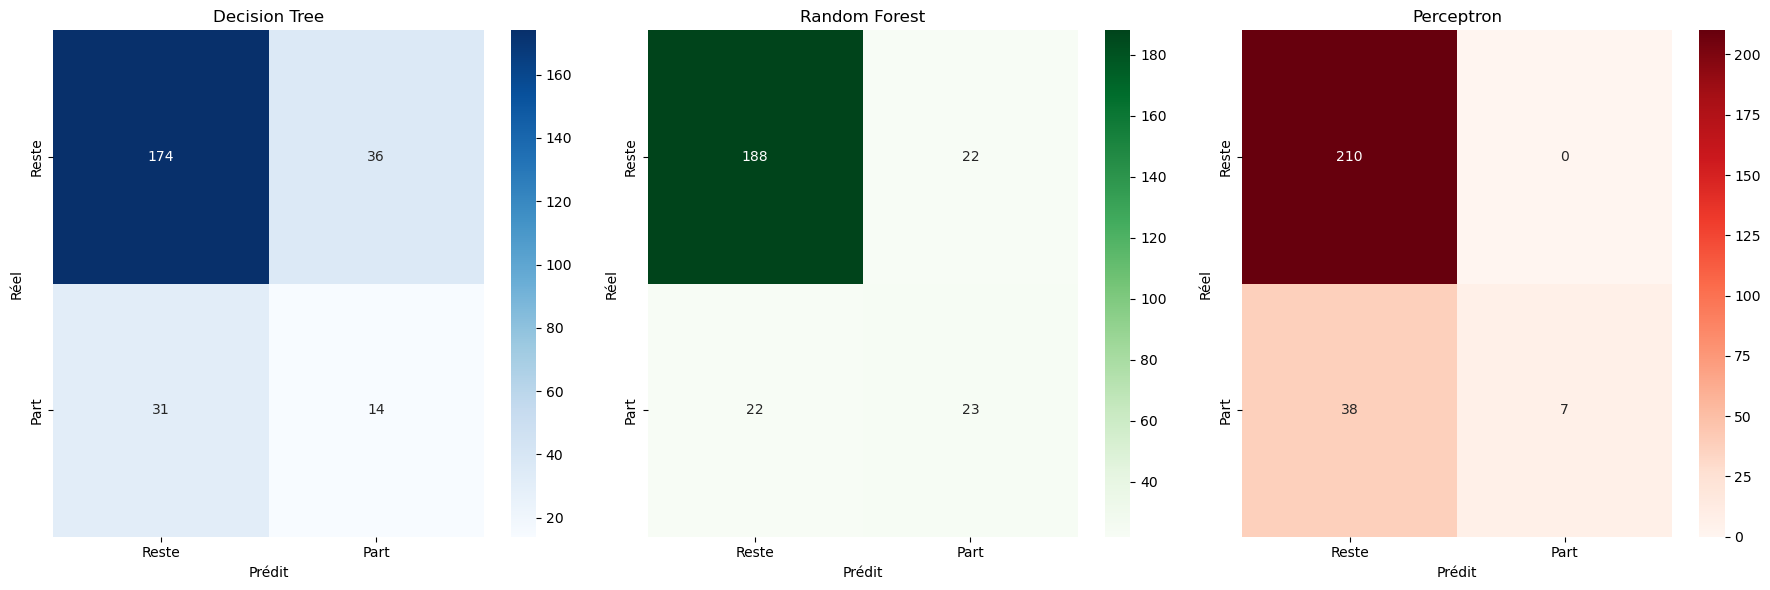

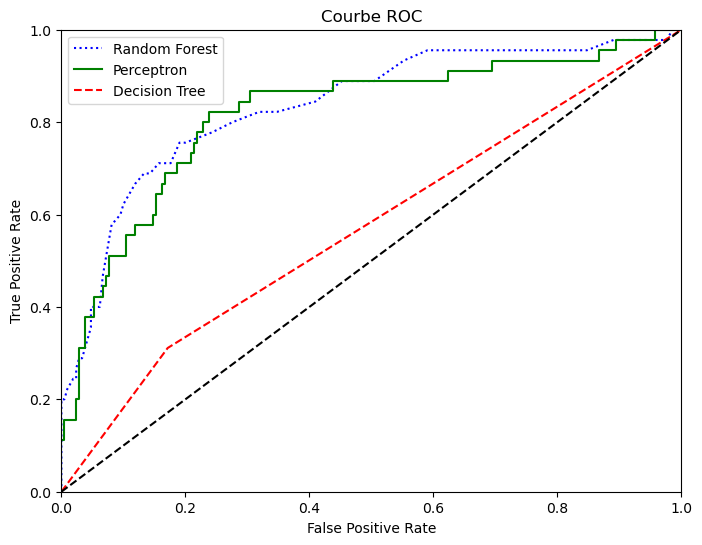

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

evaluation_tab = tab_evaluation.to_numpy()
conf_matrix = {
    "Decision Tree": evaluation_tab[0][5],
    "Perceptron": evaluation_tab[1][5],
    "Random Forest": evaluation_tab[2][5],
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
models = ["Decision Tree", "Random Forest", "Perceptron"]
colors = ["Blues", "Greens", "Reds"]

for ax, model_i, color in zip(axes, models, colors):
    sns.heatmap(conf_matrix[model_i], annot=True, fmt="d", cmap=color, ax=ax)
    ax.set_title(model_i)
    ax.set_xlabel("Prédit")
    ax.set_ylabel("Réel")
    ax.set_xticklabels(["Reste", "Part"])
    ax.set_yticklabels(["Reste", "Part"])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(model.value_roc[2], model.value_roc[3], "b:", label="Random Forest")
plt.plot(model.value_roc[4], model.value_roc[5], "g-", label="Perceptron")
plt.plot(model.value_roc[0], model.value_roc[1], "r--", label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("Courbe ROC")
plt.show()